<a href="https://colab.research.google.com/github/thalisrocha/Restoration/blob/main/TP_23_09_THALIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SECTION 1

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  3 01:55:15 2018

@author: said
"""

#%% SECTION 1 inclusion de packages externes


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
from skimage.morphology import watershed
from skimage.feature import peak_local_max

## SECTION 2

In [ ]:
#%% SECTION 2 fonctions utiles pour le TP

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat

    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' '
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1

    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat

    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' '
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'

    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1

    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def quantize(im,n=2):
    # """
    # Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux
    # """
    imt=np.float32(im.copy())
    if np.floor(n)!= n or n<2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m=imt.min()
        M=imt.max()
        imt=np.floor(n*((imt-m)/(M-m)))*(M-m)/n+m
        imt[imt==M]=M-(M-m)/n #cas des valeurs maximales
        return imt


def seuil(im,s):
    # """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    # """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def gradx(im):
    # "renvoie le gradient dans la direction x"
    imt=np.float32(im)
    gx=0*imt
    gx[:,:-1]=imt[:,1:]-imt[:,:-1]
    return gx

def grady(im):
    # "renvoie le gradient dans la direction y"
    imt=np.float32(im)
    gy=0*imt
    gy[:-1,:]=imt[1:,:]-imt[:-1,:]
    return gy

def view_spectre(im,option=1,hamming=False):
    # """ affiche le spectre d'une image
    #  si option =1 on affiche l'intensite de maniere lineaire
    #  si option =2 on affiche le log
    #  si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
    #  """
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))

    if option==1:
        viewimage(aft)
    else:
        viewimage(np.log(0.1+aft))


def filterlow(im):
    # """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))

    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    mask=(abs(XX)<tx/4) & (abs(YY)<ty/4)
    imtf=np.fft.fft2(imt)
    imtf[~mask]=0
    return np.real(np.fft.ifft2(imtf))

def filtergauss(im):
    # """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))

    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig=(tx*ty)**0.5/2/(pi**0.5)
    mask=np.exp(-(XX**2+YY**2)/2/sig**2)
    imtf=np.fft.fft2(imt)*mask
    return np.real(np.fft.ifft2(imtf))

def Get_values_without_error(im,XX,YY):
    # """ retouren une image de la taille de XX et YY
    #  qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
    #  pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp

    return imout

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
#     """
#    %
# %Effectue la transformation geometrique d'une image par
# %une rotation + homothetie
# %
# % x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
# % y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0
# %
# % theta : angle de rotation en degres
# % alpha : facteur d'homothetie (defaut=1)
# % x0, y0 : centre de la rotation (defaut=centre de l'image)
# % ech : plus proche voisin (defaut=0) ou bilineaire (1)
# % clip : format de l'image originale (defaut=True), image complete (False)
# %

#     """
    dy=im.shape[0]
    dx=im.shape[1]

    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())

    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1))

    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))

    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
#     """ renvoie la convolution de l'image avec le mask. Le calcul se fait en
# utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour
# les images en niveau de gris.
# """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def filtre_inverse(im,mask):
    # """ renvoie l'inverse de mask applique a im.
    # """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)/fft2(mm))

    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out


def median_filter(im,typ=1,r=1,xy=None):
    # """ renvoie le median de l'image im.
    # si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    # si typ==2 : disque de rayon r
    # si typ==3 alors xy est un couple de liste de x et liste de y
    #      ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois.
    #      """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre

        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)

    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy

    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def wiener(im,K,lamb=0):
    # """effectue un filtrage de wiener de l'image im par le filtre K.
    #    lamb=0 donne le filtre inverse
    #    on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
    #    avec une regularisation qui permet de ne pas trop augmenter le bruit.
    #    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2

    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty

    w2=fX**2+fY**2
    w=w2**0.5

    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+lamb*w2)
    #filtrage de wiener
    fout=g*mul

    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def wiener_modifie(im,K):
    # """effectue un filtrage de wiener de l'image im par le filtre K.
    #    lamb=0 donne le filtre inverse
    #    on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
    #    avec une regularisation qui permet de ne pas trop augmenter le bruit.
    #    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2

    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty

    w2=fX**2+fY**2
    w=w2**0.5

    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+np.var(im)*im.size/(g**2))
    #filtrage de wiener
    fout=g*mul

    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def var_image(im,x0,y0,x1,y1):
    patch=im[y0:y1+1,x0:x1+1]
    return patch.var()

In [ ]:
def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

out = get_gau_ker(3)
print(out.shape)

(17, 17)


## 1)

### 2)

In [ ]:
im2 = skio.imread('maison.tif')

im2_ppv = rotation(im2,45, alpha=1.0,x0=None,y0=None,ech=0,clip=True)
im2_bil = rotation(im2,45, alpha=1.0,x0=None,y0=None,ech=1,clip=True)

for i in range(7):
  im2_ppv = rotation(im2_ppv,45, alpha=1.0,x0=None,y0=None,ech=0,clip=True)
  im2_bil = rotation(im2_bil,45, alpha=1.0,x0=None,y0=None,ech=1,clip=True)


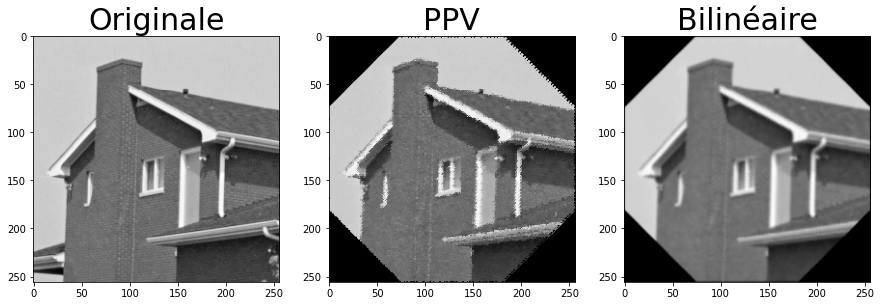

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axs[0].imshow(im2.astype("uint8"), cmap="gray")
axs[1].imshow(im2_ppv.astype("uint8"), cmap="gray")
axs[2].imshow(im2_bil.astype("uint8"), cmap="gray")
axs[0].set_title('Originale', fontdict = {'fontsize' : 30})
axs[1].set_title('PPV', fontdict = {'fontsize' : 30})
axs[2].set_title('Bilinéaire', fontdict = {'fontsize' : 30})

fig.savefig('3_1iao.png', bbox_inches="tight")


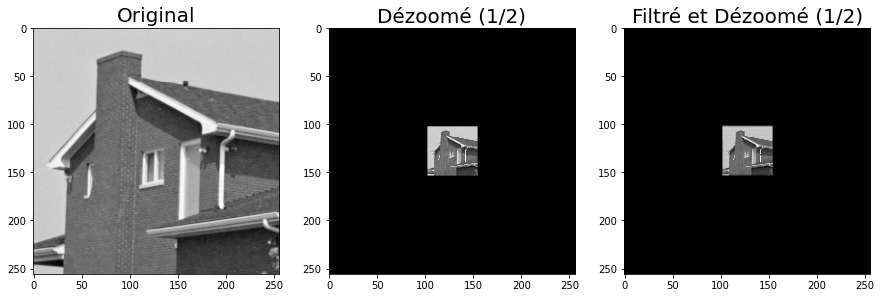

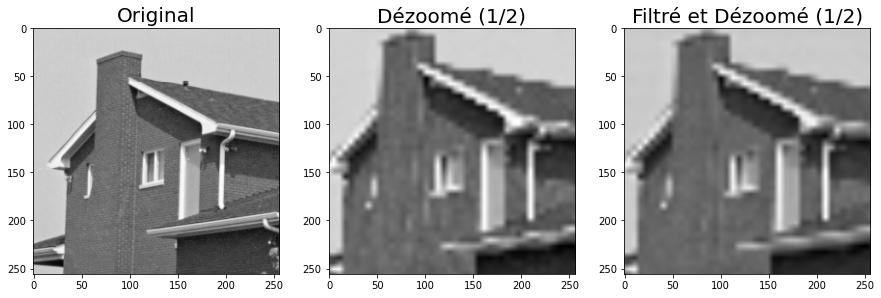

In [ ]:
im2_dezoome = rotation(im2,0, alpha=0.2,x0=None,y0=None,ech=1,clip=True)

im2_filtre = filterlow(im2)
im2_fdezoome = rotation(im2_filtre,0, alpha=0.2,x0=None,y0=None,ech=1,clip=True)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axs[0].imshow(im2.astype("uint8"), cmap="gray")
axs[1].imshow(im2_dezoome.astype("uint8"), cmap="gray")
axs[2].imshow(im2_fdezoome.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 20})
axs[1].set_title('Dézoomé (1/2)', fontdict = {'fontsize' : 20})
axs[2].set_title('Filtré et Dézoomé (1/2)', fontdict = {'fontsize' : 20})

fig.savefig('3_aisjdl.png', bbox_inches="tight")

im2_dezoome = rotation(im2_dezoome,0, alpha=6,x0=None,y0=None,ech=1,clip=True)
im2_fdezoome = rotation(im2_fdezoome,0, alpha=6,x0=None,y0=None,ech=1,clip=True)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axs[0].imshow(im2.astype("uint8"), cmap="gray")
axs[1].imshow(im2_dezoome.astype("uint8"), cmap="gray")
axs[2].imshow(im2_fdezoome.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 20})
axs[1].set_title('Dézoomé (1/2)', fontdict = {'fontsize' : 20})
axs[2].set_title('Filtré et Dézoomé (1/2)', fontdict = {'fontsize' : 20})

fig.savefig('3_alsjk.png', bbox_inches="tight")




## 3)


Variância Imagem com Ruído 1 =  12.451230553828443 
 Variância Imagem com Ruído 2 = 47.98017712078089


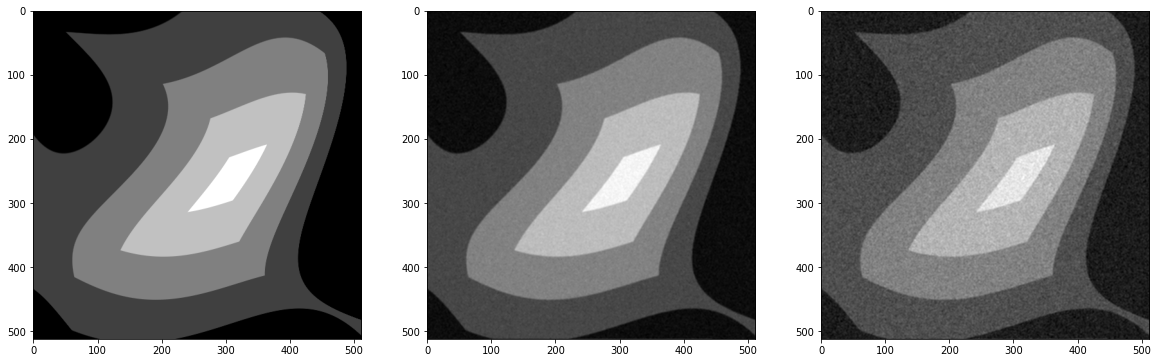

In [ ]:
mask_gauss = get_gau_ker(2)
mask_cst = get_cst_ker(3)

im3 = skio.imread('pyramide.tif')

im3_1 = filtre_lineaire(noise(im3, 8),mask_cst)
im3_2 = filtre_lineaire(noise(im3, 20), mask_cst)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im3.astype("uint8"), cmap="gray")
axs[1].imshow(im3_1.astype("uint8"), cmap="gray")
axs[2].imshow(im3_2.astype("uint8"), cmap="gray")
axs[0].set_title('')
axs[1].set_title('')
axs[2].set_title('')

var1 = var_image(im3_1,235,0,335,50)
var2 = var_image(im3_2,235,0,335,50)

print('Variância Imagem com Ruído 1 = ', var1,
      '\n Variância Imagem com Ruído 2 =', var2)

Text(0.5, 1.0, '')

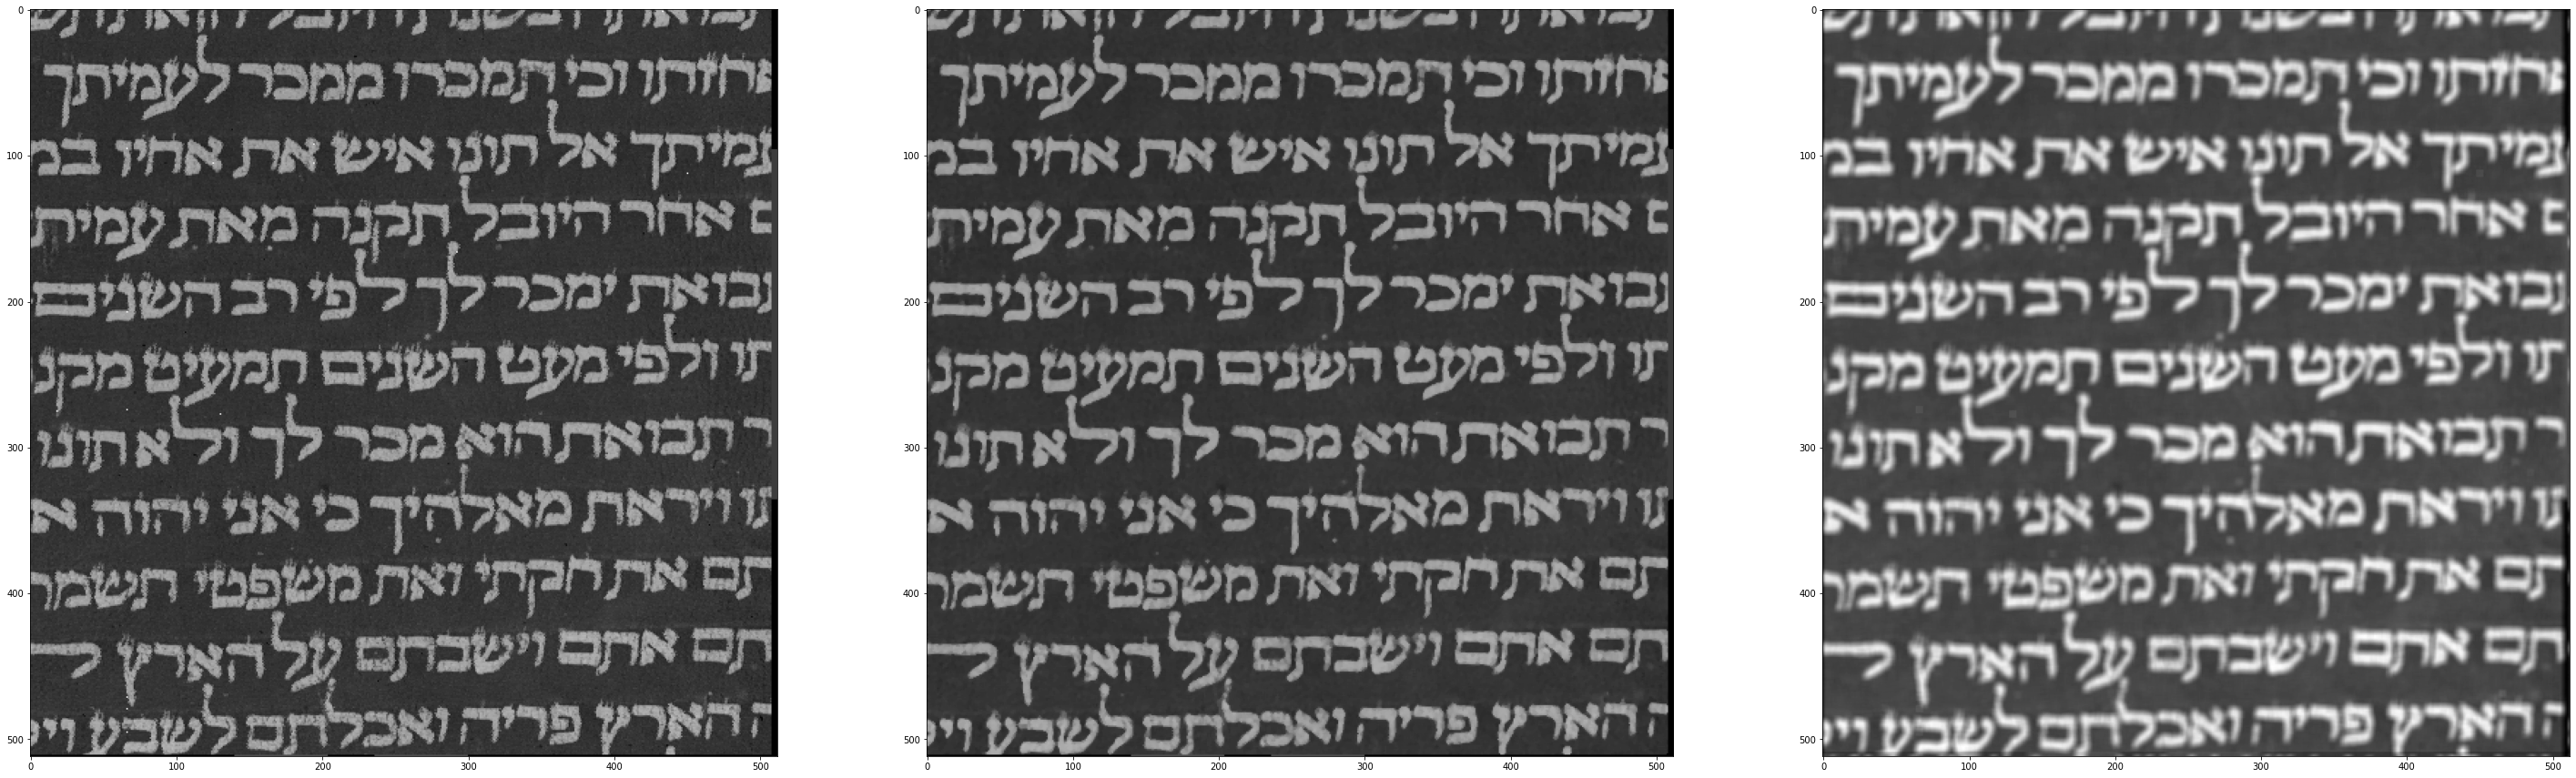

In [ ]:
im3_2 = skio.imread('hebreu.tif')

im32_lin = filtre_lineaire(im3_2,mask_cst)
im32_f = median_filter(im3_2,typ=1,r=1,xy=None)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(50, 50))
axs[0].imshow(im3_2.astype("uint8"), cmap="gray")
axs[1].imshow(im32_f.astype("uint8"), cmap="gray")
axs[2].imshow(im32_lin.astype("uint8"), cmap="gray")
axs[0].set_title('')
axs[1].set_title('')
axs[2].set_title('')

Variância Imagem com Ruído 1 =  19.316959372061774 
 Variância Imagem com Ruído 2 = 3.1758120825615053


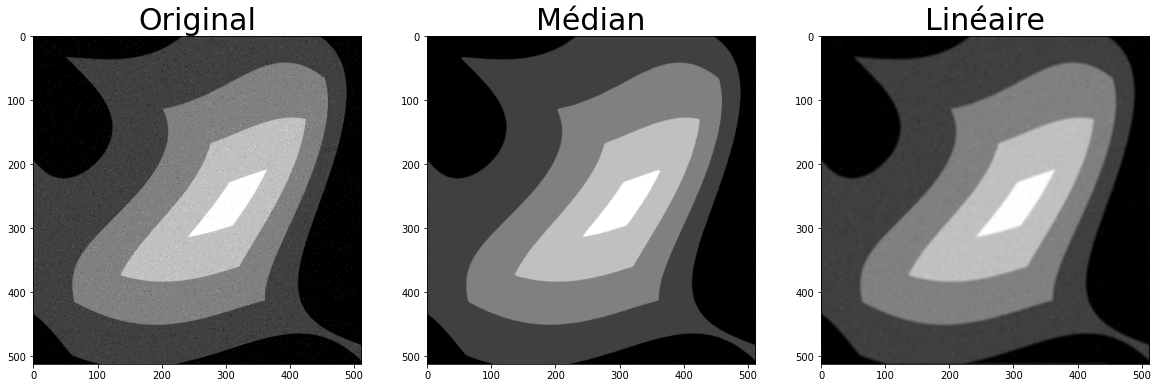

In [ ]:
im3_3 = skio.imread('pyra-impulse.tif')
mask_cst = get_cst_ker(5)

im33_lin = filtre_lineaire(im3_3,mask_cst)
im33_fmedian = median_filter(im3_3,typ=1,r=2,xy=None)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im3_3.astype("uint8"), cmap="gray")
axs[1].imshow(im33_fmedian.astype("uint8"), cmap="gray")
axs[2].imshow(im33_lin.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 30})
axs[1].set_title('Médian', fontdict = {'fontsize' : 30})
axs[2].set_title('Linéaire', fontdict = {'fontsize' : 30})


var1 = var_image(im33_lin,235,0,335,50)
var2 = var_image(im33_fmedian,235,0,335,50)

print('Variância Imagem com Ruído 1 = ', var1,
      '\n Variância Imagem com Ruído 2 =', var2)

fig.savefig('3_11.png', bbox_inches="tight")



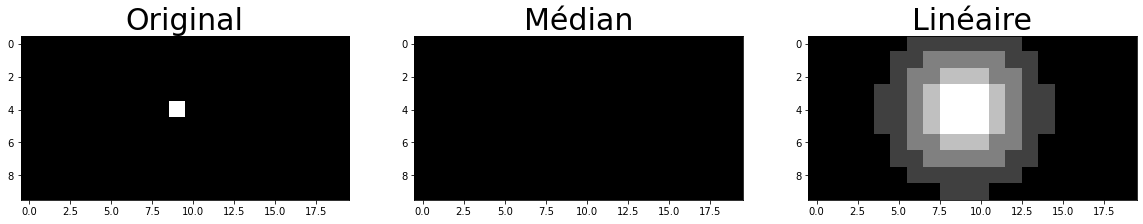

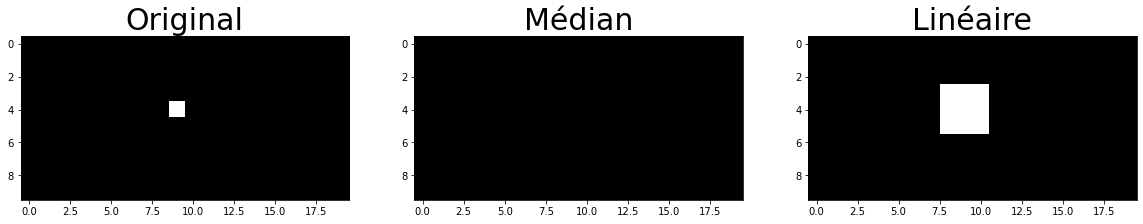

In [ ]:
im3_4 = skio.imread('carre_orig.tif')

mask_cst = get_gau_ker(3)

im33_lin = filtre_lineaire(im3_4,mask_cst)
im33_fmedian = median_filter(im3_4,typ=1,r=1,xy=None)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im3_4[45:55, 190:210].astype("uint8"), cmap="gray")
axs[1].imshow(im33_fmedian[45:55, 190:210].astype("uint8"), cmap="gray")
axs[2].imshow(im33_lin[45:55, 190:210].astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 30})
axs[1].set_title('Médian', fontdict = {'fontsize' : 30})
axs[2].set_title('Linéaire', fontdict = {'fontsize' : 30})

fig.savefig('3_12.png', bbox_inches="tight")

mask_cst = get_cst_ker(3)

im33_lin = filtre_lineaire(im3_4,mask_cst)
im33_fmedian = median_filter(im3_4,typ=1,r=1,xy=None)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im3_4[45:55, 190:210].astype("uint8"), cmap="gray")
axs[1].imshow(im33_fmedian[45:55, 190:210].astype("uint8"), cmap="gray")
axs[2].imshow(im33_lin[45:55, 190:210].astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 30})
axs[1].set_title('Médian', fontdict = {'fontsize' : 30})
axs[2].set_title('Linéaire', fontdict = {'fontsize' : 30})

fig.savefig('3_13.png', bbox_inches="tight")


# np. set_printoptions(suppress=True)
# print(im33_lin[45:55, 190:210])

## 4)


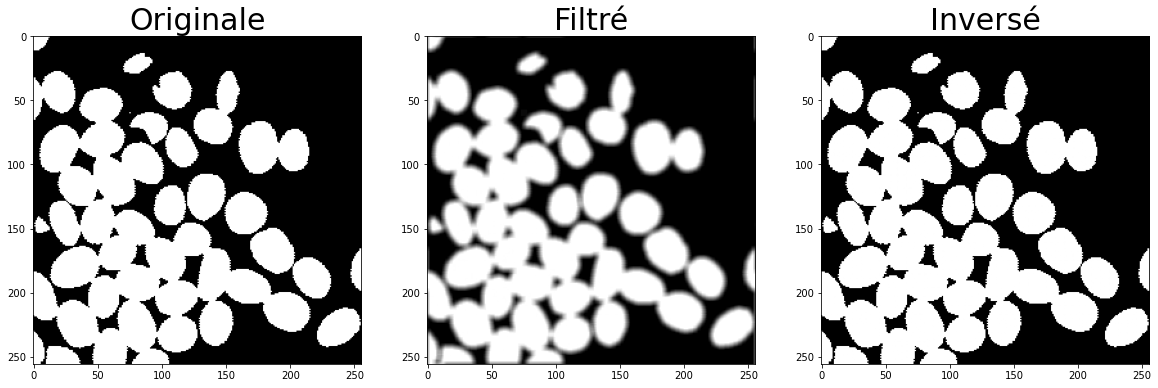

In [ ]:
im4 = skio.imread('cafe.tif')
im4_filtre = filtre_lineaire(im4,mask_cst)
im4_inverse = filtre_inverse(im4_filtre, mask_cst)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4.astype("uint8"), cmap="gray")
axs[1].imshow(im4_filtre.astype("uint8"), cmap="gray")
axs[2].imshow(im4_inverse.astype("uint8"), cmap="gray")
axs[0].set_title('Originale', fontdict = {'fontsize' : 30})
axs[1].set_title('Filtré', fontdict = {'fontsize' : 30})
axs[2].set_title('Inversé', fontdict = {'fontsize' : 30})

fig.savefig('3_14.png', bbox_inches="tight")



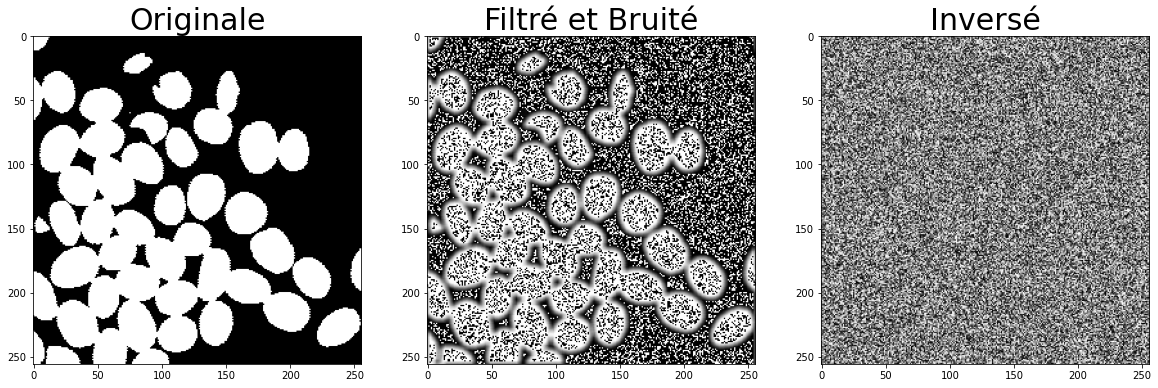

In [ ]:
im4_fbruite = noise(im4_filtre,2)

im4_inverse = filtre_inverse(im4_fbruite, mask_cst)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4.astype("uint8"), cmap="gray")
axs[1].imshow(im4_fbruite.astype("uint8"), cmap="gray")
axs[2].imshow(im4_inverse.astype("uint8"), cmap="gray")
axs[0].set_title('Originale' , fontdict = {'fontsize' : 30})
axs[1].set_title('Filtré et Bruité', fontdict = {'fontsize' : 30})
axs[2].set_title('Inversé', fontdict = {'fontsize' : 30})

fig.savefig('3_15.png', bbox_inches="tight")


(-762311.7651193278-18463.527858842554j)


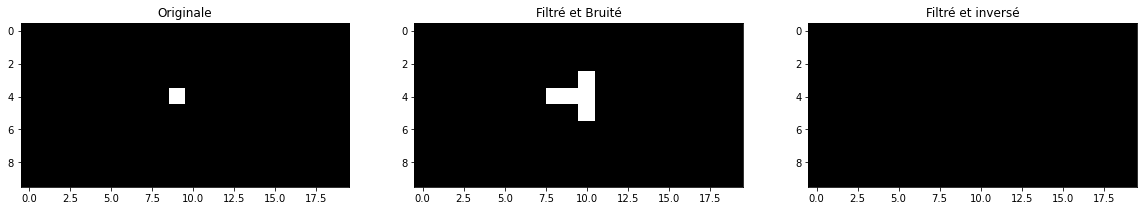

In [ ]:
im4_1 = skio.imread('carre_orig.tif')
im4_2 = skio.imread('carre_flou.tif')

# print(im4_1[40:50, 180:220])
# print(im4_2[40:50, 180:220])

fft2=np.fft.fft2
ifft2=np.fft.ifft2

im4_orig_f = fft2(im4_1)
im4_flou_f = fft2(im4_1)
aux = im4_orig_f+0.0001
print(np.min(aux))

mask_f = im4_flou_f/(aux)
mask = np.real(ifft2(mask_f))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_1[45:55, 190:210].astype("uint8"), cmap="gray")
axs[1].imshow(im4_2[45:55, 190:210].astype("uint8"), cmap="gray")
axs[2].imshow(mask[45:55, 190:210].astype("uint8"), cmap="gray")
axs[0].set_title('Originale')
axs[1].set_title('Filtré et Bruité')
axs[2].set_title('Filtré et inversé')

mask = np.array([ [0.2, 0.0, 0.0],
                  [0.2, 0.2, 0.2],
                  [0.2, 0.0, 0.0]])





### POR QUÊ?


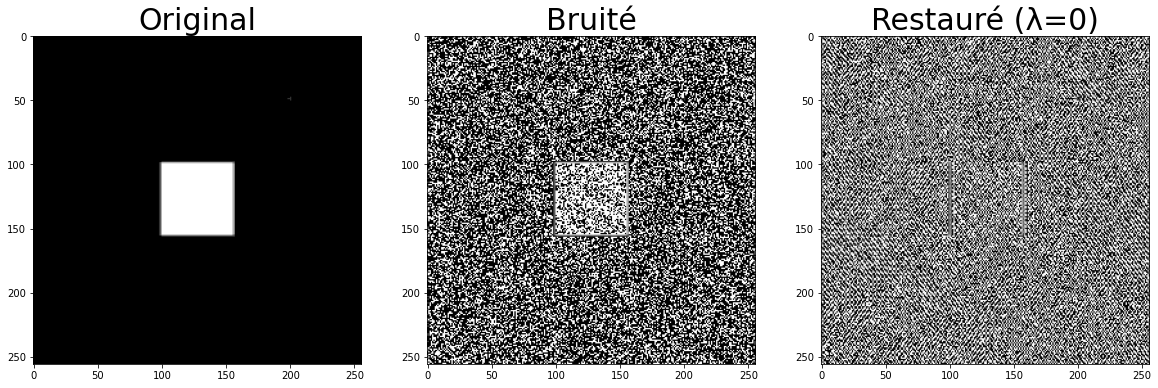

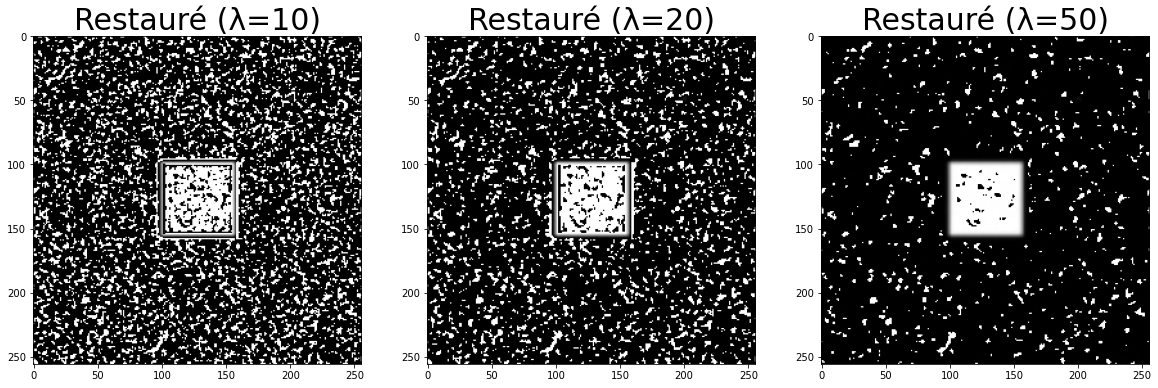

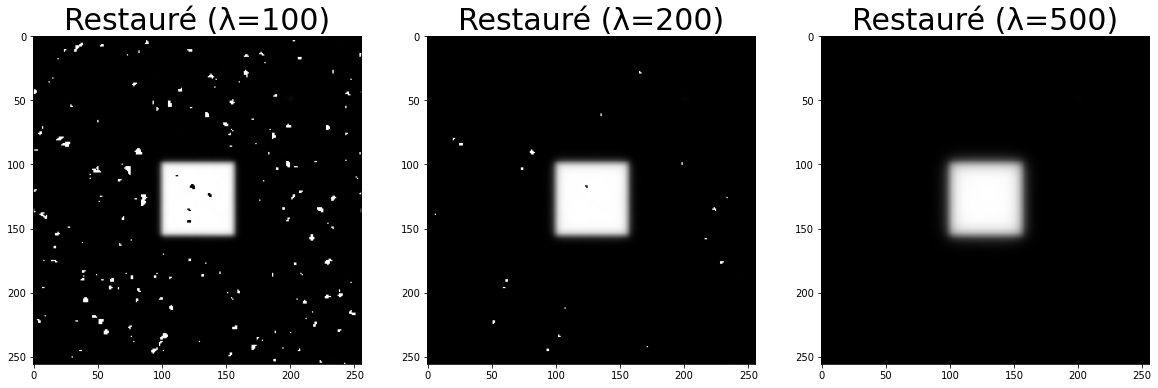

In [ ]:
im4_2noise = noise(im4_2,3)
im4_3 = wiener(im4_2noise,mask,lamb=0)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_2.astype("uint8"), cmap="gray")
axs[1].imshow(im4_2noise.astype("uint8"), cmap="gray")
axs[2].imshow(im4_3.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 30})
axs[1].set_title('Bruité', fontdict = {'fontsize' : 30})
axs[2].set_title('Restauré (λ=0)', fontdict = {'fontsize' : 30})

fig.savefig('3_15.png', bbox_inches="tight")

im4_31 = wiener(im4_2noise,mask,lamb=10)
im4_32 = wiener(im4_2noise,mask,lamb=20)
im4_33 = wiener(im4_2noise,mask,lamb=50)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_31.astype("uint8"), cmap="gray")
axs[1].imshow(im4_32.astype("uint8"), cmap="gray")
axs[2].imshow(im4_33.astype("uint8"), cmap="gray")
axs[0].set_title('Restauré (λ=10)', fontdict = {'fontsize' : 30})
axs[1].set_title('Restauré (λ=20)', fontdict = {'fontsize' : 30})
axs[2].set_title('Restauré (λ=50)', fontdict = {'fontsize' : 30})

fig.savefig('3_16.png', bbox_inches="tight")

im4_31 = wiener(im4_2noise,mask,lamb=100)
im4_32 = wiener(im4_2noise,mask,lamb=200)
im4_33 = wiener(im4_2noise,mask,lamb=500)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_31.astype("uint8"), cmap="gray")
axs[1].imshow(im4_32.astype("uint8"), cmap="gray")
axs[2].imshow(im4_33.astype("uint8"), cmap="gray")
axs[0].set_title('Restauré (λ=100)', fontdict = {'fontsize' : 30})
axs[1].set_title('Restauré (λ=200)', fontdict = {'fontsize' : 30})
axs[2].set_title('Restauré (λ=500)', fontdict = {'fontsize' : 30})

fig.savefig('3_17.png', bbox_inches="tight")

## 5)


Taille du noyau = 3 
 Variance Médian = 10.47558436558701 
 Variance Moyenne = 8.943216006874486 

Taille du noyau = 3 
 Variance Médian toute l'image = 3038.9023688427724 
 Variance Moyenne toute l'image= 2965.6651510775796 



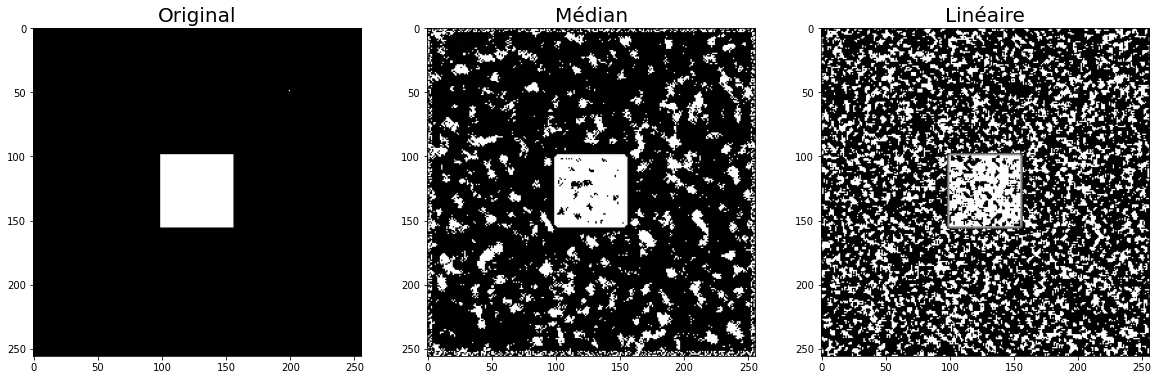

In [ ]:
im4_1noise = noise(im4_1,5)
im4_1median = median_filter(im4_1noise,typ=2,r=4,xy=None)

msize = 1
mask = get_cst_ker(msize)

im4_flinear = filtre_lineaire(im4_1noise, mask)
var1 = var_image(im4_1median,0,0,50,50)+var_image(im4_1median,0,200,50,250)
var1 = var1+var_image(im4_1median,200,0,250,50)+var_image(im4_1median,200,200,250,250)
var2 = var_image(im4_flinear,0,0,50,50)+var_image(im4_1median,0,200,50,250)
var2 = var2+var_image(im4_1median,200,0,250,50)+var_image(im4_1median,200,200,250,250)

while var2> var1:

  msize+=2
  mask = get_cst_ker(msize)
  im4_flinear = filtre_lineaire(im4_1noise, mask)
  var2 = var_image(im4_flinear,0,0,50,50)+var_image(im4_1median,0,200,50,250)
  var2 = var2+var_image(im4_1median,200,0,250,50)+var_image(im4_1median,200,200,250,250)

print("Taille du noyau =", msize, "\n",
      "Variance Médian =", var1, "\n",
      "Variance Moyenne =", var2, "\n")

var1 = var_image(im4_1median,0,0,im4_1median.shape[0],im4_1median.shape[1])
var2 = var_image(im4_flinear,0,0,im4_flinear.shape[0],im4_flinear.shape[1])
print("Taille du noyau =", msize, "\n",
      "Variance Médian toute l'image =", var1, "\n",
      "Variance Moyenne toute l'image=", var2, "\n")


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_1.astype("uint8"), cmap="gray")
axs[1].imshow(im4_1median.astype("uint8"), cmap="gray")
axs[2].imshow(im4_flinear.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 20})
axs[1].set_title('Médian', fontdict = {'fontsize' : 20})
axs[2].set_title('Linéaire', fontdict = {'fontsize' : 20})

fig.savefig('3_17.png', bbox_inches="tight")


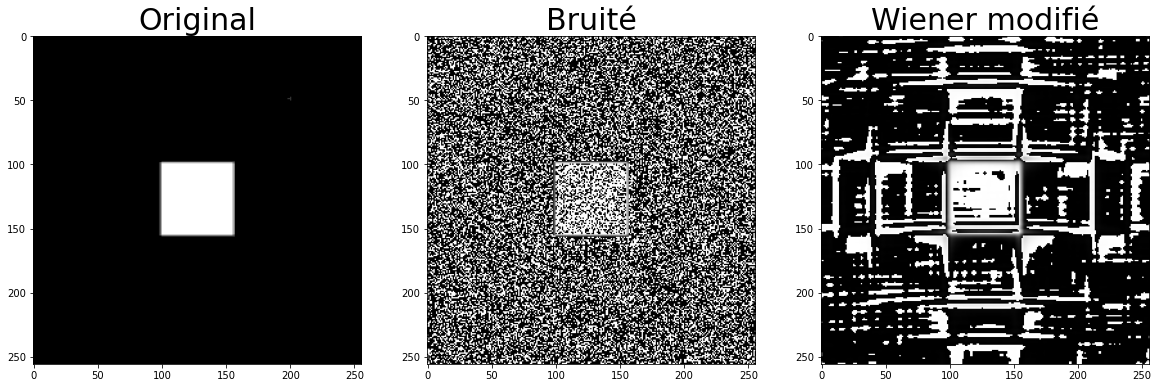

In [ ]:
br = 3
im4_2noise = noise(im4_2,br)
im4_3 = wiener_modifie(im4_2noise,mask)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axs[0].imshow(im4_2.astype("uint8"), cmap="gray")
axs[1].imshow(im4_2noise.astype("uint8"), cmap="gray")
axs[2].imshow(im4_3.astype("uint8"), cmap="gray")
axs[0].set_title('Original', fontdict = {'fontsize' : 30})
axs[1].set_title('Bruité', fontdict = {'fontsize' : 30})
axs[2].set_title('Wiener modifié', fontdict = {'fontsize' : 30})

fig.savefig('3_18.png', bbox_inches="tight")